In [3]:
import os
import glob
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from monai.data import Dataset, DataLoader
import pandas as pd

In [4]:
DATA_DIR = r"C:\Users\omer_\Documents\GitHub\ytustats\standard_u-net\Brain_Stroke_CT_Dataset"

TRAIN_CLASSES = ["Bleeding", "Ischemia", "Normal"]
class_map = {name: i for i, name in enumerate(TRAIN_CLASSES)}
print(f"Sınıflar ve etiketleri: {class_map}")

IMAGE_TYPE_FOLDER = 'DICOM' 
FILE_EXTENSION = '.dcm'

Sınıflar ve etiketleri: {'Bleeding': 0, 'Ischemia': 1, 'Normal': 2}


In [ ]:
# --- 2. EĞİTİM/DOĞRULAMA/TEST VERİLERİNİ TOPLAMA ---
image_files = []
labels = []

print("\nEğitim/Doğrulama/Test setleri için dosyalar taranıyor...")
for class_name in TRAIN_CLASSES:
    class_dir = os.path.join(DATA_DIR, class_name, IMAGE_TYPE_FOLDER)
    
    if not os.path.isdir(class_dir):
        print(f"UYARI: '{class_dir}' yolu bulunamadı, atlanıyor.")
        continue
    files_in_class = glob.glob(os.path.join(class_dir, f'*{FILE_EXTENSION}'))
    image_files.extend(files_in_class)
    labels.extend([class_map[class_name]] * len(files_in_class))

print(f"Toplam {len(image_files)} adet görüntü dosyası bulundu.")
for i, name in enumerate(TRAIN_CLASSES):
    print(f"- {name}: {labels.count(i)} adet")



Eğitim/Doğrulama/Test setleri için dosyalar taranıyor...
Toplam 6650 adet görüntü dosyası bulundu.
- Bleeding: 1093 adet
- Ischemia: 1130 adet
- Normal: 4427 adet


In [ ]:
# --- 3. VERİYİ AYIRMA (TRAIN/VALIDATION/TEST - 70/15/15) ---
X_train, X_temp, y_train, y_temp = train_test_split(
    image_files, labels, test_size=0.30, random_state=42, stratify=labels
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("\nVeri seti ayırma işlemi tamamlandı:")
print(f"Eğitim Seti (Train):   {len(X_train)} örnek")
print(f"Doğrulama Seti (Val):  {len(X_val)} örnek")
print(f"Test Seti (Bizim):     {len(X_test)} örnek")


train_data = [{"image": img_path, "label": label} for img_path, label in zip(X_train, y_train)]
val_data = [{"image": img_path, "label": label} for img_path, label in zip(X_val, y_val)]
test_data = [{"image": img_path, "label": label} for img_path, label in zip(X_test, y_test)]


Veri seti ayırma işlemi tamamlandı:
Eğitim Seti (Train):   4655 örnek
Doğrulama Seti (Val):  997 örnek
Test Seti (Bizim):     998 örnek


In [ ]:
# --- 4. EXTERNAL TEST IMPORT
external_test_data = []
external_test_dir = os.path.join(DATA_DIR, "External_Test", IMAGE_TYPE_FOLDER)
if os.path.isdir(external_test_dir):
    external_test_files = glob.glob(os.path.join(external_test_dir, f'*{FILE_EXTENSION}'))
    for img_path in external_test_files:
        external_test_data.append({"image": img_path})

    print(f"\nDış test setinden {len(external_test_data)} adet görüntü dosyası bulundu.")
else:
    print("\nDış test seti bulunamadı veya klasör mevcut değil.")
    


Dış test setinden 200 adet görüntü dosyası bulundu.


In [ ]:
# MONAI ÖN İŞLEME ZİNCİRİ(TRANSFORMS)
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    ScaleIntensityd,
    Resized,
    RandRotated,
    RandFlipd,
    ToTensord
)
train_transforms = Compose([
    LoadImaged(keys="image", image_only=True),
    EnsureChannelFirstd(keys="image"),
    ScaleIntensityd(keys="image"),
    Resized(keys="image", spatial_size=(256, 256)),
    RandRotated(keys="image", range_x=15, prob=0.5, keep_size=True),
    RandFlipd(keys="image", spatial_axis=0, prob=0.5),
    ToTensord(keys=["image", "label"])
])

val_transforms = Compose([
    LoadImaged(keys="image", image_only=True),
    EnsureChannelFirstd(keys="image"),
    ScaleIntensityd(keys="image"),
    Resized(keys="image", spatial_size=(256, 256)),
    ToTensord(keys=["image", "label"])
])

In [ ]:
# --- 6. MONAI DATASET VE DATALOADER ---
train_dataset = Dataset(data=train_data, transform=train_transforms)
val_dataset = Dataset(data=val_data, transform=val_transforms)
test_dataset = Dataset(data=test_data, transform=val_transforms)
external_test_dataset = Dataset(data=external_test_data, transform=val_transforms)

# DataLoader'lar
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)
external_test_loader = DataLoader(external_test_dataset, batch_size=8, shuffle=False, num_workers=2)

print("\nTüm DataLoader'lar başarıyla oluşturuldu.")


Tüm DataLoader'lar başarıyla oluşturuldu.



Eğitim yükleyicisi kontrolü:
Görüntülerin boyutu: torch.Size([8, 1, 256, 256])
Etiketlerin boyutu: torch.Size([8])


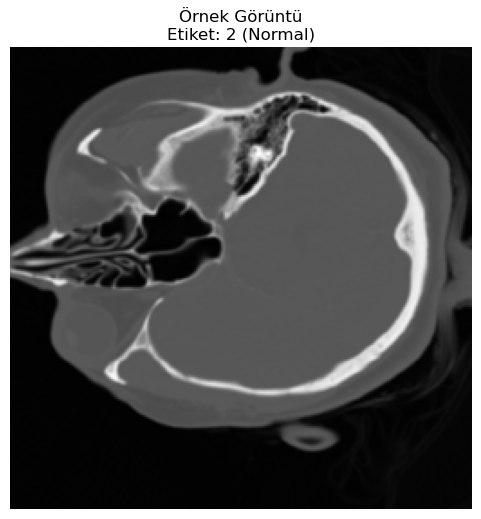

In [22]:
import matplotlib.pyplot as plt

if len(train_loader) > 0:
    check_batch = next(iter(train_loader))
    images, labels = check_batch["image"], check_batch["label"]
    print(f"\nEğitim yükleyicisi kontrolü:")
    print(f"Görüntülerin boyutu: {images.shape}")
    print(f"Etiketlerin boyutu: {labels.shape}")

    plt.figure("Veri Hattı Kontrolü", figsize=(6, 6))
    plt.imshow(images[0, 0, :, :], cmap="gray")
    plt.title(f"Örnek Görüntü\nEtiket: {labels[0].item()} ({TRAIN_CLASSES[labels[0].item()]})")
    plt.axis('off')
    plt.show()
else:
    print("\nUYARI: Eğitim yükleyicisi boş, kontrol adımı atlandı. Dosya yollarını kontrol edin.")

In [13]:
import torch
import torch.nn as nn
from torch.optim import Adam
from monai.networks.nets import UNet
from monai.losses import FocalLoss, DiceLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nKullanılan cihaz: {device}")


Kullanılan cihaz: cuda


In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
import segmentation_models_pytorch as smp
from monai.losses import FocalLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau

# --- ADIM 1: PRETRAINED U-NET MODELİ OLUŞTURMA ---
class SmpClassificationUNet(nn.Module):
    def __init__(self, encoder_name='resnet18', in_channels=1, out_channels=3):
        super().__init__()
        self.unet_base = smp.Unet(
            encoder_name=encoder_name,
            encoder_weights="imagenet", 
            in_channels=3, 
            classes=128,                 
            activation=None,
        )
    
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(128, out_channels) # 3 sınıfa ayır

    def forward(self, x):
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)
            
        features = self.unet_base(x)
        pooled_features = self.pool(features)
        pooled_features = torch.flatten(pooled_features, 1)
        output = self.classifier(pooled_features)
        return output

# Modeli oluşturup ve cihaza gönderme
model = SmpClassificationUNet(
    encoder_name="resnet18", 
    in_channels=1, 
    out_channels=len(TRAIN_CLASSES)
).to(device)


print(f"\nModel başarıyla oluşturuldu (Encoder: resnet18, Pretrained: ImageNet).")
print(f"Modelin parametre sayısı: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# --- KAYIP FONKSİYONU VE OPTİMİZASYON ---
loss_function = FocalLoss(to_onehot_y=True)

learning_rate = 1e-4
optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

print(f"\nKayıp fonksiyonu: {loss_function.__class__.__name__}")
print(f"Optimizasyon algoritması: {optimizer.__class__.__name__} (LR: {learning_rate})")


Model başarıyla oluşturuldu (Encoder: resnet18, Pretrained: ImageNet).
Modelin parametre sayısı: 14,347,011

Kayıp fonksiyonu: FocalLoss
Optimizasyon algoritması: Adam (LR: 0.0001)


c:\Users\omer_\anaconda3\envs\tdl\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [29]:
from tqdm import tqdm
import matplotlib.pyplot as plt

max_epochs = 20
val_interval = 1
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
val_loss_values = []
metric_values = []

In [30]:
for epoch in range(max_epochs):
    print("-" * 20)
    print(f"Epoch {epoch + 1}/{max_epochs}")

    model.train()
    epoch_loss = 0.0
    step = 0

    for batch_data in tqdm(train_loader, desc="Eğitim"):
        step += 1
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"Epoch {epoch + 1} için ortalama eğitim kaybı: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        
        val_epoch_loss = 0
        val_step = 0
        
        correct_predictions = 0
        total_samples = 0

        with torch.no_grad():
            for val_batch in tqdm(val_loader, desc="Doğrulama"):
                val_step += 1
                val_images, val_labels = val_batch["image"].to(device), val_batch["label"].to(device)
                val_outputs = model(val_images)
                
                loss = loss_function(val_outputs, val_labels)
                val_epoch_loss += loss.item()

                predicted_classes = torch.argmax(val_outputs, dim=1)
                correct_predictions += (predicted_classes == val_labels).sum().item()
                total_samples += val_labels.size(0)
            
            mean_val_accuracy = correct_predictions / total_samples
            metric_values.append(mean_val_accuracy)
            
            val_epoch_loss /= val_step
            val_loss_values.append(val_epoch_loss)

            if mean_val_accuracy > best_metric:
                best_metric = mean_val_accuracy
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "best_model_resnet18.pth")
                print("En iyi metrik kaydedildi!")

            print(
                f"Epoch {epoch + 1} Ortalama Doğrulama Kaybı: {val_epoch_loss:.4f} "
                f"| Doğruluk: {mean_val_accuracy:.4f}"
            )
            print(
                f"En iyi metrik şu ana kadar: {best_metric:.4f} "
                f"(epoch {best_metric_epoch})")

    scheduler.step(val_epoch_loss)


print(f"\nEğitim tamamlandı. En iyi model 'best_model_resnet18.pth' olarak kaydedildi.")

--------------------
Epoch 1/20


Eğitim: 100%|██████████| 582/582 [01:16<00:00,  7.58it/s]


Epoch 1 için ortalama eğitim kaybı: 0.1148


Doğrulama: 100%|██████████| 125/125 [00:25<00:00,  4.96it/s]


En iyi metrik kaydedildi!
Epoch 1 Ortalama Doğrulama Kaybı: 0.0985 | Doğruluk: 0.6971
En iyi metrik şu ana kadar: 0.6971 (epoch 1)
--------------------
Epoch 2/20


Eğitim: 100%|██████████| 582/582 [01:11<00:00,  8.15it/s]


Epoch 2 için ortalama eğitim kaybı: 0.0992


Doğrulama: 100%|██████████| 125/125 [00:24<00:00,  5.09it/s]


En iyi metrik kaydedildi!
Epoch 2 Ortalama Doğrulama Kaybı: 0.0737 | Doğruluk: 0.8154
En iyi metrik şu ana kadar: 0.8154 (epoch 2)
--------------------
Epoch 3/20


Eğitim: 100%|██████████| 582/582 [01:10<00:00,  8.23it/s]


Epoch 3 için ortalama eğitim kaybı: 0.0874


Doğrulama: 100%|██████████| 125/125 [00:25<00:00,  4.87it/s]


En iyi metrik kaydedildi!
Epoch 3 Ortalama Doğrulama Kaybı: 0.0674 | Doğruluk: 0.8485
En iyi metrik şu ana kadar: 0.8485 (epoch 3)
--------------------
Epoch 4/20


Eğitim: 100%|██████████| 582/582 [01:13<00:00,  7.92it/s]


Epoch 4 için ortalama eğitim kaybı: 0.0768


Doğrulama: 100%|██████████| 125/125 [00:26<00:00,  4.68it/s]


En iyi metrik kaydedildi!
Epoch 4 Ortalama Doğrulama Kaybı: 0.0524 | Doğruluk: 0.8917
En iyi metrik şu ana kadar: 0.8917 (epoch 4)
--------------------
Epoch 5/20


Eğitim: 100%|██████████| 582/582 [01:18<00:00,  7.39it/s]


Epoch 5 için ortalama eğitim kaybı: 0.0663


Doğrulama: 100%|██████████| 125/125 [00:26<00:00,  4.70it/s]


En iyi metrik kaydedildi!
Epoch 5 Ortalama Doğrulama Kaybı: 0.0450 | Doğruluk: 0.9147
En iyi metrik şu ana kadar: 0.9147 (epoch 5)
--------------------
Epoch 6/20


Eğitim: 100%|██████████| 582/582 [01:17<00:00,  7.54it/s]


Epoch 6 için ortalama eğitim kaybı: 0.0606


Doğrulama: 100%|██████████| 125/125 [00:23<00:00,  5.22it/s]


Epoch 6 Ortalama Doğrulama Kaybı: 0.0492 | Doğruluk: 0.8877
En iyi metrik şu ana kadar: 0.9147 (epoch 5)
--------------------
Epoch 7/20


Eğitim: 100%|██████████| 582/582 [01:10<00:00,  8.25it/s]


Epoch 7 için ortalama eğitim kaybı: 0.0564


Doğrulama: 100%|██████████| 125/125 [00:24<00:00,  5.19it/s]


Epoch 7 Ortalama Doğrulama Kaybı: 0.0451 | Doğruluk: 0.8997
En iyi metrik şu ana kadar: 0.9147 (epoch 5)
--------------------
Epoch 8/20


Eğitim: 100%|██████████| 582/582 [01:10<00:00,  8.23it/s]


Epoch 8 için ortalama eğitim kaybı: 0.0541


Doğrulama: 100%|██████████| 125/125 [00:24<00:00,  5.18it/s]


En iyi metrik kaydedildi!
Epoch 8 Ortalama Doğrulama Kaybı: 0.0410 | Doğruluk: 0.9188
En iyi metrik şu ana kadar: 0.9188 (epoch 8)
--------------------
Epoch 9/20


Eğitim: 100%|██████████| 582/582 [01:11<00:00,  8.14it/s]


Epoch 9 için ortalama eğitim kaybı: 0.0511


Doğrulama: 100%|██████████| 125/125 [00:24<00:00,  5.20it/s]


En iyi metrik kaydedildi!
Epoch 9 Ortalama Doğrulama Kaybı: 0.0321 | Doğruluk: 0.9348
En iyi metrik şu ana kadar: 0.9348 (epoch 9)
--------------------
Epoch 10/20


Eğitim: 100%|██████████| 582/582 [01:12<00:00,  8.04it/s]


Epoch 10 için ortalama eğitim kaybı: 0.0456


Doğrulama: 100%|██████████| 125/125 [00:24<00:00,  5.13it/s]


En iyi metrik kaydedildi!
Epoch 10 Ortalama Doğrulama Kaybı: 0.0283 | Doğruluk: 0.9478
En iyi metrik şu ana kadar: 0.9478 (epoch 10)
--------------------
Epoch 11/20


Eğitim: 100%|██████████| 582/582 [01:17<00:00,  7.49it/s]


Epoch 11 için ortalama eğitim kaybı: 0.0447


Doğrulama: 100%|██████████| 125/125 [00:26<00:00,  4.71it/s]


Epoch 11 Ortalama Doğrulama Kaybı: 0.0336 | Doğruluk: 0.9338
En iyi metrik şu ana kadar: 0.9478 (epoch 10)
--------------------
Epoch 12/20


Eğitim: 100%|██████████| 582/582 [01:19<00:00,  7.35it/s]


Epoch 12 için ortalama eğitim kaybı: 0.0429


Doğrulama: 100%|██████████| 125/125 [00:27<00:00,  4.49it/s]


Epoch 12 Ortalama Doğrulama Kaybı: 0.0307 | Doğruluk: 0.9418
En iyi metrik şu ana kadar: 0.9478 (epoch 10)
--------------------
Epoch 13/20


Eğitim: 100%|██████████| 582/582 [01:18<00:00,  7.40it/s]


Epoch 13 için ortalama eğitim kaybı: 0.0429


Doğrulama: 100%|██████████| 125/125 [00:25<00:00,  4.90it/s]


Epoch 13 Ortalama Doğrulama Kaybı: 0.0303 | Doğruluk: 0.9418
En iyi metrik şu ana kadar: 0.9478 (epoch 10)
--------------------
Epoch 14/20


Eğitim: 100%|██████████| 582/582 [01:17<00:00,  7.55it/s]


Epoch 14 için ortalama eğitim kaybı: 0.0387


Doğrulama: 100%|██████████| 125/125 [00:25<00:00,  4.97it/s]


Epoch 14 Ortalama Doğrulama Kaybı: 0.0349 | Doğruluk: 0.9318
En iyi metrik şu ana kadar: 0.9478 (epoch 10)
--------------------
Epoch 15/20


Eğitim: 100%|██████████| 582/582 [01:17<00:00,  7.55it/s]


Epoch 15 için ortalama eğitim kaybı: 0.0312


Doğrulama: 100%|██████████| 125/125 [00:25<00:00,  4.95it/s]


En iyi metrik kaydedildi!
Epoch 15 Ortalama Doğrulama Kaybı: 0.0208 | Doğruluk: 0.9629
En iyi metrik şu ana kadar: 0.9629 (epoch 15)
--------------------
Epoch 16/20


Eğitim: 100%|██████████| 582/582 [01:16<00:00,  7.59it/s]


Epoch 16 için ortalama eğitim kaybı: 0.0257


Doğrulama: 100%|██████████| 125/125 [00:25<00:00,  4.91it/s]


En iyi metrik kaydedildi!
Epoch 16 Ortalama Doğrulama Kaybı: 0.0197 | Doğruluk: 0.9679
En iyi metrik şu ana kadar: 0.9679 (epoch 16)
--------------------
Epoch 17/20


Eğitim: 100%|██████████| 582/582 [01:18<00:00,  7.45it/s]


Epoch 17 için ortalama eğitim kaybı: 0.0248


Doğrulama: 100%|██████████| 125/125 [00:26<00:00,  4.67it/s]


Epoch 17 Ortalama Doğrulama Kaybı: 0.0179 | Doğruluk: 0.9679
En iyi metrik şu ana kadar: 0.9679 (epoch 16)
--------------------
Epoch 18/20


Eğitim: 100%|██████████| 582/582 [01:19<00:00,  7.35it/s]


Epoch 18 için ortalama eğitim kaybı: 0.0240


Doğrulama: 100%|██████████| 125/125 [00:26<00:00,  4.71it/s]


Epoch 18 Ortalama Doğrulama Kaybı: 0.0198 | Doğruluk: 0.9609
En iyi metrik şu ana kadar: 0.9679 (epoch 16)
--------------------
Epoch 19/20


Eğitim: 100%|██████████| 582/582 [01:18<00:00,  7.38it/s]


Epoch 19 için ortalama eğitim kaybı: 0.0214


Doğrulama: 100%|██████████| 125/125 [00:26<00:00,  4.66it/s]


En iyi metrik kaydedildi!
Epoch 19 Ortalama Doğrulama Kaybı: 0.0169 | Doğruluk: 0.9699
En iyi metrik şu ana kadar: 0.9699 (epoch 19)
--------------------
Epoch 20/20


Eğitim: 100%|██████████| 582/582 [01:18<00:00,  7.45it/s]


Epoch 20 için ortalama eğitim kaybı: 0.0208


Doğrulama: 100%|██████████| 125/125 [00:25<00:00,  4.95it/s]

En iyi metrik kaydedildi!
Epoch 20 Ortalama Doğrulama Kaybı: 0.0169 | Doğruluk: 0.9719
En iyi metrik şu ana kadar: 0.9719 (epoch 20)

Eğitim tamamlandı. En iyi model 'best_model_resnet18.pth' olarak kaydedildi.


C:\Users\omer_\AppData\Local\Temp\ipykernel_36436\3220650518.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_resnet18.pth"))


             NİHAİ TEST SONUÇLARI (Classification Report)
              precision    recall  f1-score   support

    Bleeding       0.96      0.93      0.94       164
    Ischemia       0.91      0.94      0.92       170
      Normal       0.98      0.98      0.98       664

    accuracy                           0.97       998
   macro avg       0.95      0.95      0.95       998
weighted avg       0.97      0.97      0.97       998


                     Karışıklık Matrisi


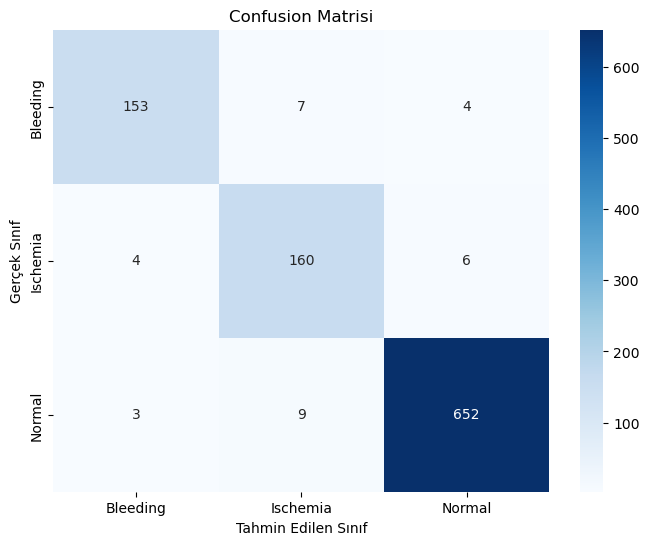

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

model.load_state_dict(torch.load("best_model_resnet18.pth"))
model.eval() 

y_true = []
y_pred = []

with torch.no_grad():
    for test_data_batch in tqdm(test_loader, desc="Nihai Test"):
        test_images, test_labels = test_data_batch["image"].to(device), test_data_batch["label"].to(device)
        
        test_outputs = model(test_images)
        predicted_classes = torch.argmax(test_outputs, dim=1)
        
        y_pred.extend(predicted_classes.cpu().numpy())
        y_true.extend(test_labels.cpu().numpy())

print("\n" + "="*50)
print("             NİHAİ TEST SONUÇLARI (Classification Report)")
print("="*50)
print(classification_report(y_true, y_pred, target_names=TRAIN_CLASSES))
print("\n" + "="*50)
print("                     Karışıklık Matrisi")
print("="*50)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=TRAIN_CLASSES, yticklabels=TRAIN_CLASSES)
plt.xlabel("Tahmin Edilen Sınıf")
plt.ylabel("Gerçek Sınıf")
plt.title("Confusion Matrisi")
plt.show()

## Hibrit Model

In [ ]:
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from monai.networks.nets import UNet
import torch
import numpy as np
import os
from monai.data import Dataset

class HybridDataset(Dataset):
    def __init__(self, image_files_and_labels, tda_dir, transform=None):
        # ... (init kısmı aynı)
        self.image_files_and_labels = image_files_and_labels
        self.tda_dir = tda_dir
        self.transform = transform
    
    def __len__(self):
        # ... (len kısmı aynı)
        return len(self.image_files_and_labels)

    def __getitem__(self, index):
        item_metadata = self.image_files_and_labels[index]
        
        if self.transform:
            processed_item = self.transform(item_metadata)
        else:
            processed_item = item_metadata
        
        image_path = item_metadata['image']
        base_filename = os.path.basename(image_path)
        filename_without_ext = os.path.splitext(base_filename)[0]
        npy_path = os.path.join(self.tda_dir, f"{filename_without_ext}.npy")
        
        if os.path.exists(npy_path):
            tda_feature_raw = np.load(npy_path) # Şekli (2, 32, 32)
            
            # --- İki homoloji boyutunu birleştiriyoruz ---
            # İki adet (32, 32)'lik görüntüyü tek bir (2, 32, 32) tensör olarak ele alacağız.
            # Artık (1, 32, 32) yerine (2, 32, 32) olacak.
            processed_item['tda_feature'] = torch.from_numpy(tda_feature_raw).float()

        else:
            print(f"UYARI: {npy_path} bulunamadı!")
            # Boyutun tutarlı olması için (2, 32, 32)'lik sıfır tensörü oluşturuyoruz
            processed_item['tda_feature'] = torch.zeros((2, 32, 32), dtype=torch.float32)

        return processed_item

# --- Yeni DataLoader'lar ---
TDA_DIR = "./topological_features_cubical" 

# 1. Faz'daki veri listelerimizi (train_data, val_data, test_data) ve transformlarımızı (train_transforms, val_transforms) burada tekrar kullanıyoruz.

# Hibrit Dataset'lerimizi oluşturalım
hybrid_train_dataset = HybridDataset(train_data, TDA_DIR, transform=train_transforms)
hybrid_val_dataset = HybridDataset(val_data, TDA_DIR, transform=val_transforms)
hybrid_test_dataset = HybridDataset(test_data, TDA_DIR, transform=val_transforms)

# Yeni Hibrit DataLoader'lar
hybrid_train_loader = DataLoader(hybrid_train_dataset, batch_size=8, shuffle=True, num_workers=0)
hybrid_val_loader = DataLoader(hybrid_val_dataset, batch_size=8, shuffle=False, num_workers=0)
hybrid_test_loader = DataLoader(hybrid_test_dataset, batch_size=8, shuffle=False, num_workers=0)

print("Hibrit veri yükleyicileri başarıyla oluşturuldu.")
check_batch = next(iter(hybrid_train_loader))
print("\nBir batch hibrit veri kontrolü:")
print(f"Görüntü tensörünün boyutu: {check_batch['image'].shape}")
print(f"TDA özellik tensörünün boyutu: {check_batch['tda_feature'].shape}")
print(f"Etiket tensörünün boyutu: {check_batch['label'].shape}")

Hibrit veri yükleyicileri başarıyla oluşturuldu.

Bir batch hibrit veri kontrolü:
Görüntü tensörünün boyutu: torch.Size([8, 1, 256, 256])
TDA özellik tensörünün boyutu: torch.Size([8, 2, 32, 32])
Etiket tensörünün boyutu: torch.Size([8])


In [ ]:
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
from monai.losses import FocalLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau

class HybridResNetUNet(nn.Module):
    def __init__(self, encoder_name='resnet18', in_channels=1, out_channels=3):
        super().__init__()
        
        # 1. GÖRSEL ÖZELLİK ÇIKARICI: Önceden eğitilmiş ResNet18 tabanlı U-Net
        self.tda_weight = nn.Parameter(torch.tensor(0.5))

        self.unet_base = smp.Unet(
            encoder_name=encoder_name,
            encoder_weights="imagenet",  
            in_channels=3,             
            classes=32,                  
            activation=None,
        )
        
        # 2. TDA ÖZELLİK İŞLEYİCİ:  Girdi: (batch, 2, 32, 32). Çıktı: (batch, 128)
        self.tda_processor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2 * 32 * 32, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128)
        )
        
        # 3. BİRLEŞTİRİCİ VE SINIFLANDIRICI: Bu da öncekiyle aynı mantıkta. U-Net'in özellik haritasını tek bir vektöre indirgemek için havuzlama katmanı.
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # U-Net'ten gelen özellik (32) + TDA'dan gelen özellik (128) = 160
        self.final_classifier = nn.Sequential(
            nn.Linear(32 + 128, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, out_channels)
        )

    def forward(self, image, tda_feature):
        # A. Görüntü Kolu girdi 1 kanallı ise, ResNet'in beklediği 3 kanala çıkar
        if image.shape[1] == 1:
            image = image.repeat(1, 3, 1, 1)
            
        # 1. Görüntüyü U-Net'ten geçir -> (batch, 32, H, W)
        image_features = self.unet_base(image)
        
        # 2. U-Net çıktısını havuzlayarak tek bir vektöre indirge -> (batch, 32)
        pooled_image_features = self.pool(image_features)
        flat_image_features = torch.flatten(pooled_image_features, 1)
        
        # B. TDA Kolu. 3. TDA özelliğini işle -> (batch, 128)
        processed_tda_feature = self.tda_processor(tda_feature)
        
        # C. Birleştirme 4. İki vektörü birleştir -> (batch, 32 + 128 = 160)
        combined_features = torch.cat([flat_image_features, processed_tda_feature], dim=1)
        
        # 5. Son sınıflandırma
        output = self.final_classifier(combined_features)
        
        return output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Yeni hibrit model
hybrid_model = HybridResNetUNet(
    encoder_name="resnet18", 
    in_channels=1, 
    out_channels=len(TRAIN_CLASSES)
).to(device)

# Optimizer ve diğer ayarlar aynı
optimizer = torch.optim.Adam(hybrid_model.parameters(), lr=5e-5)
weights = torch.tensor([4.0, 4.0, 1.0], dtype=torch.float32).to(device)
loss_function = nn.CrossEntropyLoss(weight=weights)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

print("\nResNet18 tabanlı hibrit model başarıyla oluşturuldu.")
print(f"Modelin parametre sayısı: {sum(p.numel() for p in hybrid_model.parameters() if p.requires_grad):,}")


ResNet18 tabanlı hibrit model başarıyla oluşturuldu.
Modelin parametre sayısı: 14,900,644


In [ ]:
# --- HİBRİT EĞİTİM AYARLARI ---
max_epochs = 20
val_interval = 1
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
val_loss_values = []
metric_values = [] 
# --- EĞİTİM VE DOĞRULAMA DÖNGÜSÜ ---
from torch.optim.lr_scheduler import ReduceLROnPlateau
for epoch in range(max_epochs):
    print("-" * 20)
    print(f"Epoch {epoch + 1}/{max_epochs}")
    
    hybrid_model.train()
    epoch_loss = 0
    step = 0
    
    for batch_data in tqdm(hybrid_train_loader, desc="Hibrit Eğitim"):
        step += 1
        inputs, tda_features, labels = (
            batch_data["image"].to(device),
            batch_data["tda_feature"].to(device),
            batch_data["label"].to(device),
        )
        
        optimizer.zero_grad()
        outputs = hybrid_model(inputs, tda_features)
        loss = loss_function(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(hybrid_model.parameters(), 1.0)
        optimizer.step()
        
        epoch_loss += loss.item()
    
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"Epoch {epoch + 1} Ortalama Eğitim Kaybı: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        hybrid_model.eval()
        val_epoch_loss = 0
        val_step = 0
        correct_predictions = 0
        total_samples = 0

        with torch.no_grad():
            for val_batch in tqdm(hybrid_val_loader, desc="Hibrit Doğrulama"):
                val_step += 1
                val_images, val_tda, val_labels = (
                    val_batch["image"].to(device),
                    val_batch["tda_feature"].to(device),
                    val_batch["label"].to(device),
                )
                val_outputs = hybrid_model(val_images, val_tda)
                loss = loss_function(val_outputs, val_labels)
                val_epoch_loss += loss.item()
                predicted_classes = torch.argmax(val_outputs, dim=1)
                correct_predictions += (predicted_classes == val_labels).sum().item()
                total_samples += val_labels.size(0)
            
            mean_val_accuracy = correct_predictions / total_samples
            metric_values.append(mean_val_accuracy)
            
            val_epoch_loss /= val_step
            val_loss_values.append(val_epoch_loss)

            if mean_val_accuracy > best_metric:
                best_metric = mean_val_accuracy
                best_metric_epoch = epoch + 1
                torch.save(hybrid_model.state_dict(), "best_hybrid_model.pth")
                print("yeni en iyi hibrit metrik kaydedildi!")

            print(
                f"Epoch {epoch + 1} Ortalama Doğrulama Kaybı: {val_epoch_loss:.4f} "
                f"| Doğruluk: {mean_val_accuracy:.4f}"
            )
            print(
                f"En iyi metrik şu ana kadar: {best_metric:.4f} "
                f"(epoch {best_metric_epoch})")
            
        scheduler.step(val_epoch_loss)

print(f"\nHibrit eğitim tamamlandı. En iyi model 'best_hybrid_model.pth' olarak kaydedildi.")

--------------------
Epoch 1/20


Hibrit Eğitim: 100%|██████████| 582/582 [02:48<00:00,  3.45it/s]


Epoch 1 Ortalama Eğitim Kaybı: 1.0283


Hibrit Doğrulama: 100%|██████████| 125/125 [00:27<00:00,  4.54it/s]


yeni en iyi hibrit metrik kaydedildi!
Epoch 1 Ortalama Doğrulama Kaybı: 0.8686 | Doğruluk: 0.7172
En iyi metrik şu ana kadar: 0.7172 (epoch 1)
--------------------
Epoch 2/20


Hibrit Eğitim: 100%|██████████| 582/582 [03:00<00:00,  3.23it/s]


Epoch 2 Ortalama Eğitim Kaybı: 0.8634


Hibrit Doğrulama: 100%|██████████| 125/125 [00:31<00:00,  3.99it/s]


yeni en iyi hibrit metrik kaydedildi!
Epoch 2 Ortalama Doğrulama Kaybı: 0.6015 | Doğruluk: 0.8576
En iyi metrik şu ana kadar: 0.8576 (epoch 2)
--------------------
Epoch 3/20


Hibrit Eğitim: 100%|██████████| 582/582 [02:56<00:00,  3.29it/s]


Epoch 3 Ortalama Eğitim Kaybı: 0.7579


Hibrit Doğrulama: 100%|██████████| 125/125 [00:28<00:00,  4.36it/s]


Epoch 3 Ortalama Doğrulama Kaybı: 0.5812 | Doğruluk: 0.8495
En iyi metrik şu ana kadar: 0.8576 (epoch 2)
--------------------
Epoch 4/20


Hibrit Eğitim: 100%|██████████| 582/582 [02:58<00:00,  3.27it/s]


Epoch 4 Ortalama Eğitim Kaybı: 0.6567


Hibrit Doğrulama: 100%|██████████| 125/125 [00:29<00:00,  4.24it/s]


yeni en iyi hibrit metrik kaydedildi!
Epoch 4 Ortalama Doğrulama Kaybı: 0.3752 | Doğruluk: 0.9168
En iyi metrik şu ana kadar: 0.9168 (epoch 4)
--------------------
Epoch 5/20


Hibrit Eğitim: 100%|██████████| 582/582 [02:57<00:00,  3.27it/s]


Epoch 5 Ortalama Eğitim Kaybı: 0.5821


Hibrit Doğrulama: 100%|██████████| 125/125 [00:29<00:00,  4.23it/s]


yeni en iyi hibrit metrik kaydedildi!
Epoch 5 Ortalama Doğrulama Kaybı: 0.2682 | Doğruluk: 0.9188
En iyi metrik şu ana kadar: 0.9188 (epoch 5)
--------------------
Epoch 6/20


Hibrit Eğitim: 100%|██████████| 582/582 [02:56<00:00,  3.29it/s]


Epoch 6 Ortalama Eğitim Kaybı: 0.5336


Hibrit Doğrulama: 100%|██████████| 125/125 [00:29<00:00,  4.28it/s]


yeni en iyi hibrit metrik kaydedildi!
Epoch 6 Ortalama Doğrulama Kaybı: 0.3354 | Doğruluk: 0.9218
En iyi metrik şu ana kadar: 0.9218 (epoch 6)
--------------------
Epoch 7/20


Hibrit Eğitim: 100%|██████████| 582/582 [03:03<00:00,  3.17it/s]


Epoch 7 Ortalama Eğitim Kaybı: 0.5375


Hibrit Doğrulama: 100%|██████████| 125/125 [00:30<00:00,  4.10it/s]


Epoch 7 Ortalama Doğrulama Kaybı: 0.4290 | Doğruluk: 0.9168
En iyi metrik şu ana kadar: 0.9218 (epoch 6)
--------------------
Epoch 8/20


Hibrit Eğitim: 100%|██████████| 582/582 [02:59<00:00,  3.24it/s]


Epoch 8 Ortalama Eğitim Kaybı: 0.4669


Hibrit Doğrulama: 100%|██████████| 125/125 [00:30<00:00,  4.09it/s]


yeni en iyi hibrit metrik kaydedildi!
Epoch 8 Ortalama Doğrulama Kaybı: 0.2932 | Doğruluk: 0.9348
En iyi metrik şu ana kadar: 0.9348 (epoch 8)
--------------------
Epoch 9/20


Hibrit Eğitim: 100%|██████████| 582/582 [02:58<00:00,  3.26it/s]


Epoch 9 Ortalama Eğitim Kaybı: 0.4784


Hibrit Doğrulama: 100%|██████████| 125/125 [00:30<00:00,  4.15it/s]


Epoch 9 Ortalama Doğrulama Kaybı: 0.3253 | Doğruluk: 0.9178
En iyi metrik şu ana kadar: 0.9348 (epoch 8)
--------------------
Epoch 10/20


Hibrit Eğitim: 100%|██████████| 582/582 [02:57<00:00,  3.28it/s]


Epoch 10 Ortalama Eğitim Kaybı: 0.4806


Hibrit Doğrulama: 100%|██████████| 125/125 [00:29<00:00,  4.30it/s]


Epoch 10 Ortalama Doğrulama Kaybı: 0.3022 | Doğruluk: 0.9117
En iyi metrik şu ana kadar: 0.9348 (epoch 8)
--------------------
Epoch 11/20


Hibrit Eğitim: 100%|██████████| 582/582 [02:54<00:00,  3.34it/s]


Epoch 11 Ortalama Eğitim Kaybı: 0.4309


Hibrit Doğrulama: 100%|██████████| 125/125 [00:28<00:00,  4.31it/s]


Epoch 11 Ortalama Doğrulama Kaybı: 0.4489 | Doğruluk: 0.9077
En iyi metrik şu ana kadar: 0.9348 (epoch 8)
--------------------
Epoch 12/20


Hibrit Eğitim: 100%|██████████| 582/582 [02:54<00:00,  3.34it/s]


Epoch 12 Ortalama Eğitim Kaybı: 0.3554


Hibrit Doğrulama: 100%|██████████| 125/125 [00:29<00:00,  4.28it/s]


yeni en iyi hibrit metrik kaydedildi!
Epoch 12 Ortalama Doğrulama Kaybı: 0.2489 | Doğruluk: 0.9488
En iyi metrik şu ana kadar: 0.9488 (epoch 12)
--------------------
Epoch 13/20


Hibrit Eğitim: 100%|██████████| 582/582 [02:54<00:00,  3.33it/s]


Epoch 13 Ortalama Eğitim Kaybı: 0.3399


Hibrit Doğrulama: 100%|██████████| 125/125 [00:28<00:00,  4.31it/s]


yeni en iyi hibrit metrik kaydedildi!
Epoch 13 Ortalama Doğrulama Kaybı: 0.2398 | Doğruluk: 0.9549
En iyi metrik şu ana kadar: 0.9549 (epoch 13)
--------------------
Epoch 14/20


Hibrit Eğitim: 100%|██████████| 582/582 [02:57<00:00,  3.28it/s]


Epoch 14 Ortalama Eğitim Kaybı: 0.2751


Hibrit Doğrulama: 100%|██████████| 125/125 [00:30<00:00,  4.16it/s]


yeni en iyi hibrit metrik kaydedildi!
Epoch 14 Ortalama Doğrulama Kaybı: 0.2361 | Doğruluk: 0.9619
En iyi metrik şu ana kadar: 0.9619 (epoch 14)
--------------------
Epoch 15/20


Hibrit Eğitim: 100%|██████████| 582/582 [02:58<00:00,  3.26it/s]


Epoch 15 Ortalama Eğitim Kaybı: 0.2839


Hibrit Doğrulama: 100%|██████████| 125/125 [00:28<00:00,  4.45it/s]


yeni en iyi hibrit metrik kaydedildi!
Epoch 15 Ortalama Doğrulama Kaybı: 0.2303 | Doğruluk: 0.9649
En iyi metrik şu ana kadar: 0.9649 (epoch 15)
--------------------
Epoch 16/20


Hibrit Eğitim: 100%|██████████| 582/582 [02:47<00:00,  3.47it/s]


Epoch 16 Ortalama Eğitim Kaybı: 0.2889


Hibrit Doğrulama: 100%|██████████| 125/125 [00:27<00:00,  4.53it/s]


Epoch 16 Ortalama Doğrulama Kaybı: 0.2522 | Doğruluk: 0.9629
En iyi metrik şu ana kadar: 0.9649 (epoch 15)
--------------------
Epoch 17/20


Hibrit Eğitim: 100%|██████████| 582/582 [02:55<00:00,  3.32it/s]


Epoch 17 Ortalama Eğitim Kaybı: 0.2572


Hibrit Doğrulama: 100%|██████████| 125/125 [00:28<00:00,  4.32it/s]


yeni en iyi hibrit metrik kaydedildi!
Epoch 17 Ortalama Doğrulama Kaybı: 0.2192 | Doğruluk: 0.9669
En iyi metrik şu ana kadar: 0.9669 (epoch 17)
--------------------
Epoch 18/20


Hibrit Eğitim: 100%|██████████| 582/582 [02:57<00:00,  3.28it/s]


Epoch 18 Ortalama Eğitim Kaybı: 0.2730


Hibrit Doğrulama: 100%|██████████| 125/125 [00:29<00:00,  4.19it/s]


Epoch 18 Ortalama Doğrulama Kaybı: 0.1897 | Doğruluk: 0.9669
En iyi metrik şu ana kadar: 0.9669 (epoch 17)
--------------------
Epoch 19/20


Hibrit Eğitim: 100%|██████████| 582/582 [02:55<00:00,  3.31it/s]


Epoch 19 Ortalama Eğitim Kaybı: 0.2514


Hibrit Doğrulama: 100%|██████████| 125/125 [00:29<00:00,  4.17it/s]


yeni en iyi hibrit metrik kaydedildi!
Epoch 19 Ortalama Doğrulama Kaybı: 0.2315 | Doğruluk: 0.9689
En iyi metrik şu ana kadar: 0.9689 (epoch 19)
--------------------
Epoch 20/20


Hibrit Eğitim: 100%|██████████| 582/582 [02:55<00:00,  3.32it/s]


Epoch 20 Ortalama Eğitim Kaybı: 0.2439


Hibrit Doğrulama: 100%|██████████| 125/125 [00:28<00:00,  4.33it/s]


yeni en iyi hibrit metrik kaydedildi!
Epoch 20 Ortalama Doğrulama Kaybı: 0.2115 | Doğruluk: 0.9699
En iyi metrik şu ana kadar: 0.9699 (epoch 20)

Hibrit eğitim tamamlandı. En iyi model 'best_hybrid_model.pth' olarak kaydedildi.


## External 

Dahili test seti için 998 elemanlı veri yükleyiciler oluşturuldu.


Test Seti Tahminleri (Hybrid): 100%|██████████| 125/125 [00:27<00:00,  4.54it/s]



--- Alternatif 2: Ayrı ve Temiz Raporlar ---

--- Baseline Model (ResNet18) Sınıflandırma Raporu ---
              precision    recall  f1-score   support

    Bleeding       0.96      0.93      0.94       164
    Ischemia       0.91      0.94      0.92       170
      Normal       0.98      0.98      0.98       664

    accuracy                           0.97       998
   macro avg       0.95      0.95      0.95       998
weighted avg       0.97      0.97      0.97       998


--------------------------------------------------

--- Hibrit Model (ResNet18 + TDA) Sınıflandırma Raporu ---
              precision    recall  f1-score   support

    Bleeding       0.98      0.94      0.96       164
    Ischemia       0.96      0.95      0.95       170
      Normal       0.98      0.99      0.98       664

    accuracy                           0.97       998
   macro avg       0.97      0.96      0.97       998
weighted avg       0.97      0.97      0.97       998


--- Karşılaştırmalı Kar

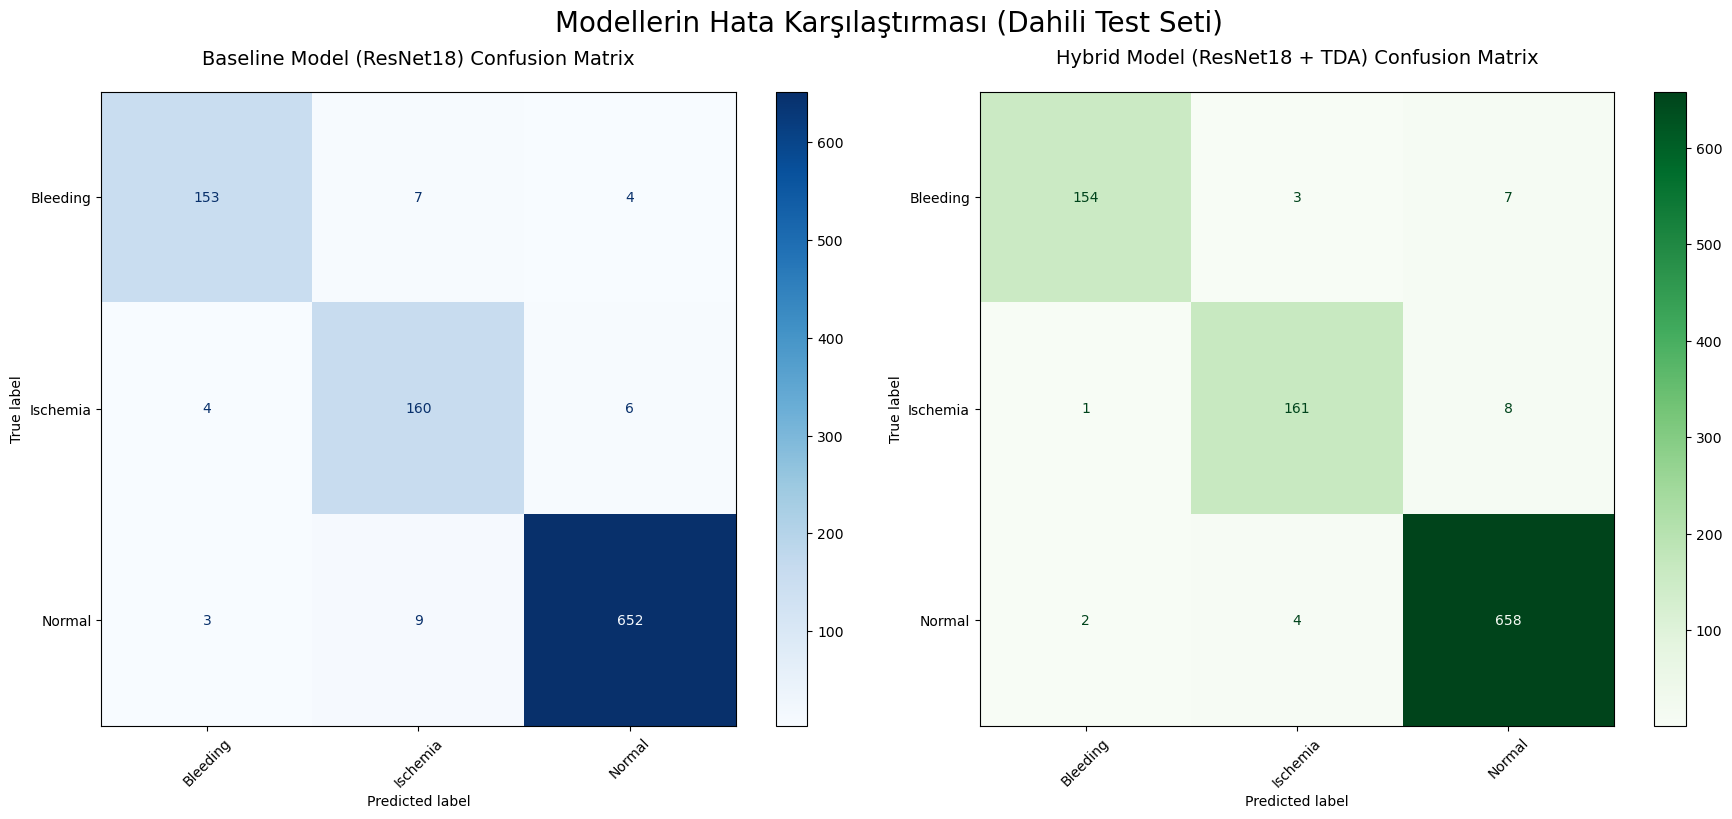

In [ ]:
import torch
import pandas as pd
from tqdm import tqdm
import os
from monai.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# --- Dahili Test Seti İçin Veri Yükleyiciler ---
baseline_test_dataset = Dataset(data=test_data, transform=val_transforms)
baseline_test_loader = DataLoader(baseline_test_dataset, batch_size=8, shuffle=False, num_workers=0)

hybrid_test_dataset = HybridDataset(
    image_files_and_labels=test_data, 
    tda_dir=TDA_DIR, 
    transform=val_transforms
)
hybrid_test_loader = DataLoader(hybrid_test_dataset, batch_size=8, shuffle=False, num_workers=0)
print(f"Dahili test seti için {len(baseline_test_dataset)} elemanlı veri yükleyiciler oluşturuldu.")

# --- Tahmin ve Gerçek Etiketleri Toplayacak Fonksiyon ---
def get_predictions_and_labels(model, data_loader, model_type="baseline"):
    all_preds, all_labels = [], []
    model.eval()
    with torch.no_grad():
        for batch_data in tqdm(data_loader, desc=f"Test Seti Tahminleri ({model_type.capitalize()})"):
            labels = batch_data["label"]
            inputs = batch_data["image"].to(device)
            if model_type == "hybrid":
                tda_features = batch_data["tda_feature"].to(device)
                outputs = model(inputs, tda_features)
            else:
                outputs = model(inputs)
            predicted_indices = torch.argmax(outputs, dim=1)
            all_preds.extend(predicted_indices.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

# --- Tahminleri ve Etiketleri Hesaplama ---
y_pred_baseline, y_true_baseline = get_predictions_and_labels(baseline_model, baseline_test_loader, "baseline")
y_pred_hybrid, y_true_hybrid = get_predictions_and_labels(hybrid_model, hybrid_test_loader, "hybrid")

# =================================================================
# KARŞILAŞTIRMALI SINIFLANDIRMA RAPORU
# =================================================================
print("\n" + "="*50)
print("--- Alternatif 2: Ayrı ve Temiz Raporlar ---")
print("="*50 + "\n")
target_names = TRAIN_CLASSES
report_str_baseline = classification_report(y_true_baseline, y_pred_baseline, target_names=target_names)
report_str_hybrid = classification_report(y_true_hybrid, y_pred_hybrid, target_names=target_names)
print("--- Baseline Model (ResNet18) Sınıflandırma Raporu ---")
print(report_str_baseline)
print("\n" + "-"*50 + "\n")
print("--- Hibrit Model (ResNet18 + TDA) Sınıflandırma Raporu ---")
print(report_str_hybrid)


# =================================================================
# KARŞILAŞTIRMALI KARMAŞIKLIK MATRİSİ
# =================================================================
print("\n" + "="*50)
print("--- Karşılaştırmalı Karmaşıklık Matrisi (Confusion Matrix) ---")
print("="*50 + "\n")

cm_baseline = confusion_matrix(y_true_baseline, y_pred_baseline)
cm_hybrid = confusion_matrix(y_true_hybrid, y_pred_hybrid)
class_labels = TRAIN_CLASSES

fig, axes = plt.subplots(1, 2, figsize=(18, 8))
disp_baseline = ConfusionMatrixDisplay(confusion_matrix=cm_baseline, display_labels=class_labels)
disp_baseline.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Baseline Model (ResNet18) Confusion Matrix', pad=20, fontsize=14)
axes[0].tick_params(axis='x', labelrotation=45)

disp_hybrid = ConfusionMatrixDisplay(confusion_matrix=cm_hybrid, display_labels=class_labels)
disp_hybrid.plot(ax=axes[1], cmap='Greens', values_format='d')
axes[1].set_title('Hybrid Model (ResNet18 + TDA) Confusion Matrix', pad=20, fontsize=14)
axes[1].tick_params(axis='x', labelrotation=45)

plt.suptitle('Modellerin Hata Karşılaştırması (Dahili Test Seti)', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Örnek Görüntü Sınıfı: Ischemia


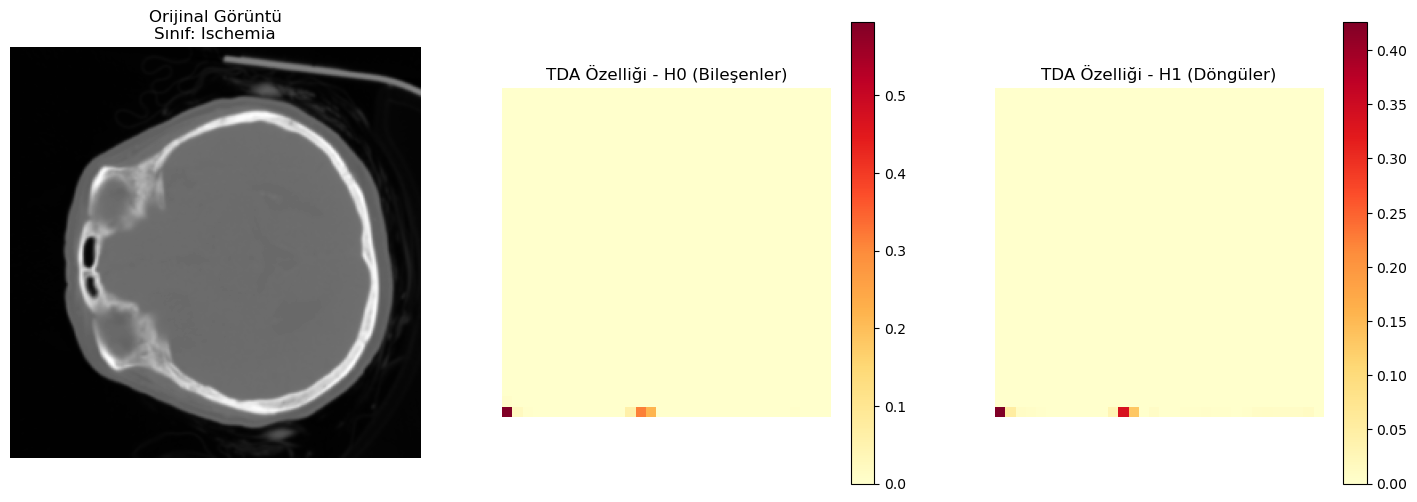

In [ ]:
import matplotlib.pyplot as plt
import torch


sample_batch = next(iter(hybrid_test_loader))
images = sample_batch['image']
tda_features = sample_batch['tda_feature']
labels = sample_batch['label']
sample_idx = 0
image_sample = images[sample_idx].squeeze() # (256, 256)
tda_sample = tda_features[sample_idx]       # (2, 32, 32)
label_sample_idx = labels[sample_idx].item()
label_sample_name = TRAIN_CLASSES[label_sample_idx]

print(f"Örnek Görüntü Sınıfı: {label_sample_name}")


fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Orijinal Görüntü
axes[0].imshow(image_sample, cmap='gray')
axes[0].set_title(f'Orijinal Görüntü\nSınıf: {label_sample_name}')
axes[0].axis('off')

# 2. TDA Özelliği - H0 (Bağlantı Bileşenleri)
im1 = axes[1].imshow(tda_sample[0], cmap='YlOrRd')
axes[1].set_title('TDA Özelliği - H0 (Bileşenler)')
axes[1].axis('off')
fig.colorbar(im1, ax=axes[1])

# 3. TDA Özelliği - H1 (Döngüler)
im2 = axes[2].imshow(tda_sample[1], cmap='YlOrRd')
axes[2].set_title('TDA Özelliği - H1 (Döngüler)')
axes[2].axis('off')
fig.colorbar(im2, ax=axes[2])

plt.show()

c:\Users\omer_\anaconda3\envs\tdl\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\omer_\anaconda3\envs\tdl\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



Görselleştirilen Örnek Sınıfı: Bleeding


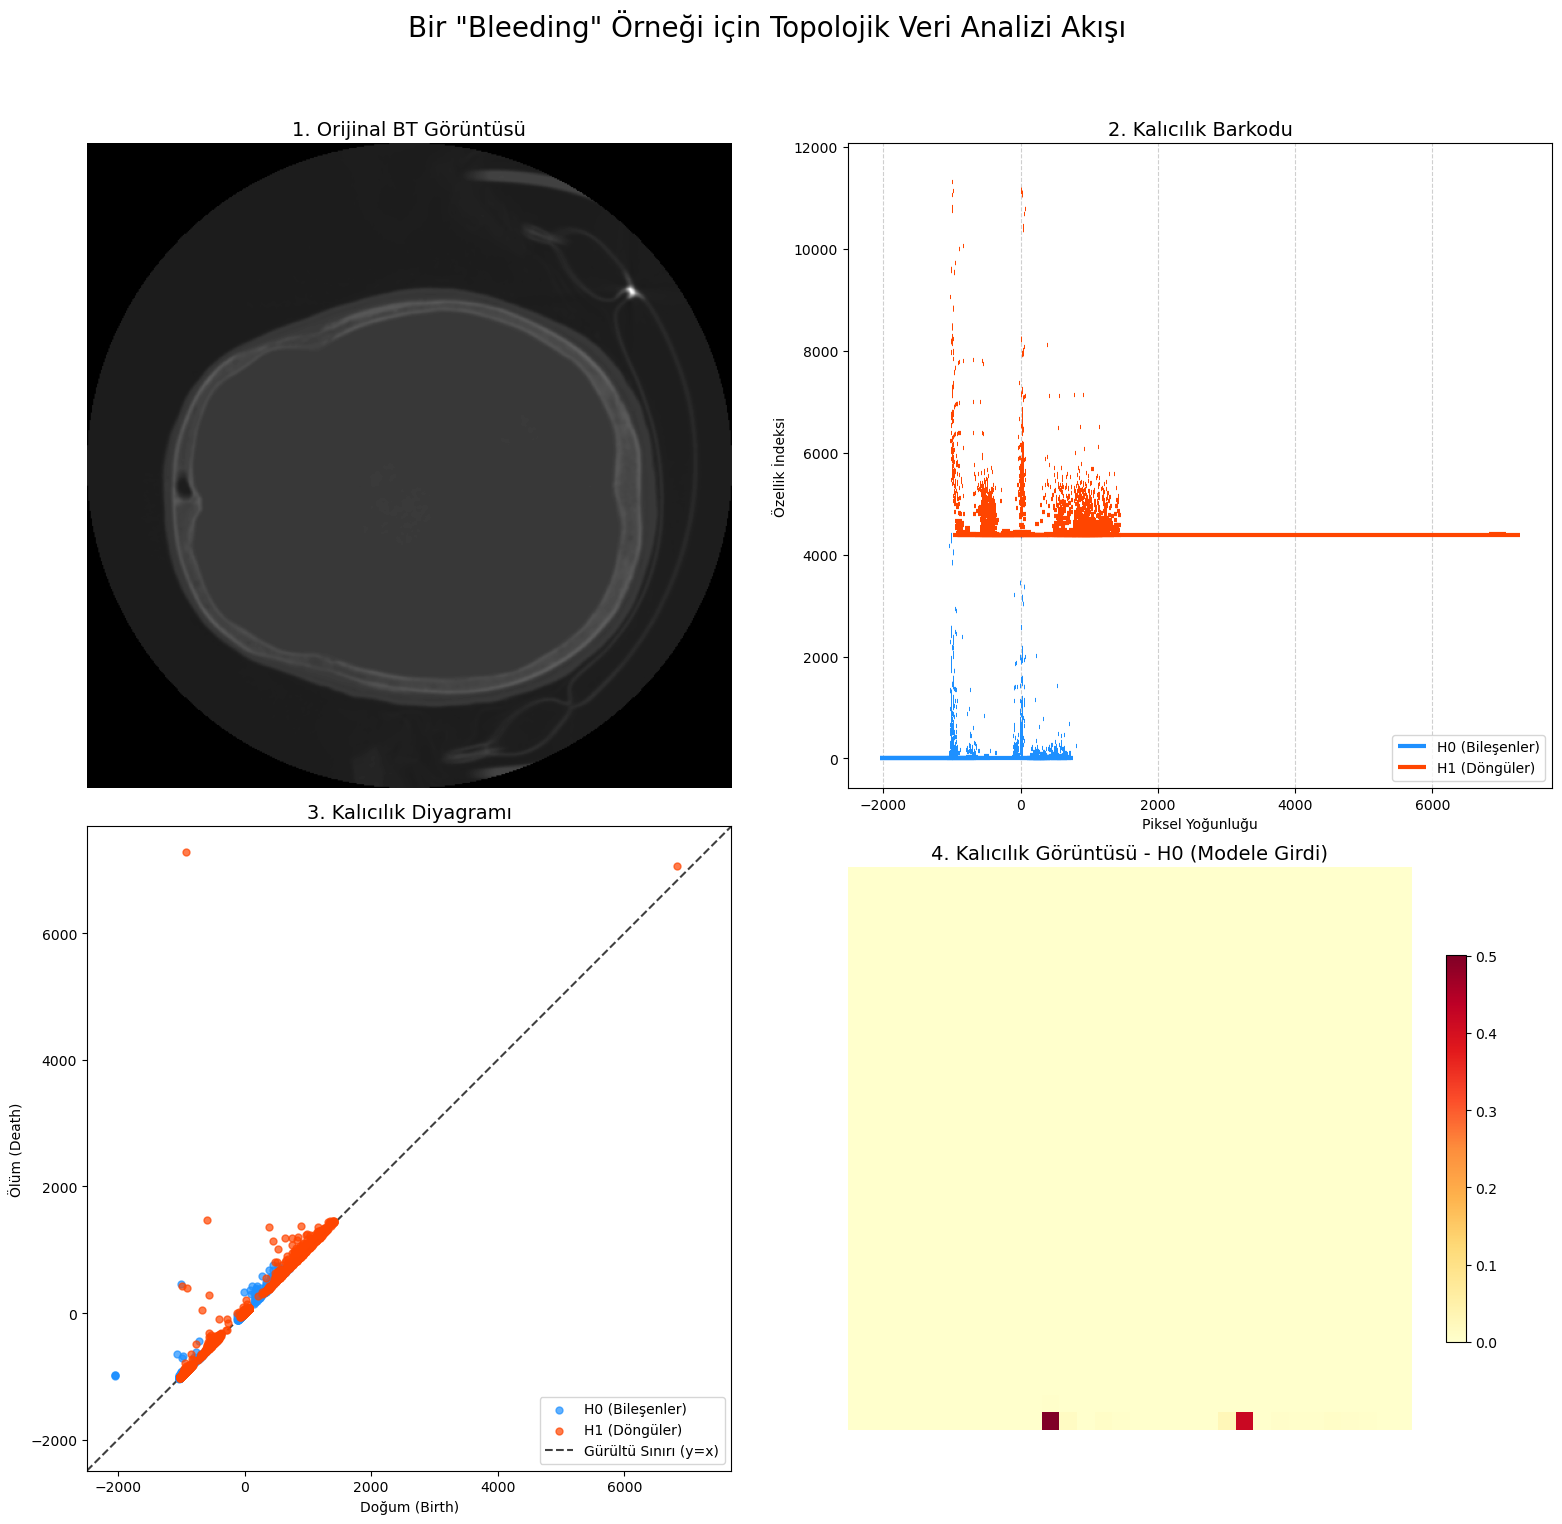

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from monai.transforms import LoadImage 
from gtda.homology import CubicalPersistence

# ---  Manuel Barkod Çizim Fonksiyonu ---
def plot_barcode_manual(diagram_data, ax):
    """Verilen kalıcılık diyagramı verisinden bir barkod çizer."""
    h0_features = diagram_data[diagram_data[:, 2] == 0]
    h1_features = diagram_data[diagram_data[:, 2] == 1]
    current_y = 0
    if len(h0_features) > 0:
        y_coords = np.arange(current_y, current_y + len(h0_features))
        ax.hlines(y_coords, h0_features[:, 0], h0_features[:, 1], color='dodgerblue', lw=3, label='H0 (Bileşenler)')
        current_y += len(h0_features)
    if len(h1_features) > 0:
        y_coords = np.arange(current_y, current_y + len(h1_features))
        ax.hlines(y_coords, h1_features[:, 0], h1_features[:, 1], color='orangered', lw=3, label='H1 (Döngüler)')
    ax.set_xlabel("Piksel Yoğunluğu")
    ax.set_ylabel("Özellik İndeksi")
    ax.legend(loc='lower right')
    ax.grid(axis='x', linestyle='--', alpha=0.6)

# ---  Manuel Diyagram Çizim Fonksiyonu ---
def plot_diagram_manual(diagram_data, ax):
    """Verilen kalıcılık diyagramı verisinden bir diyagram çizer."""
    h0_points = diagram_data[diagram_data[:, 2] == 0]
    h1_points = diagram_data[diagram_data[:, 2] == 1]

    # H0 (bileşenler) noktalarını çiz
    ax.scatter(h0_points[:, 0], h0_points[:, 1], c='dodgerblue', label='H0 (Bileşenler)', s=25, alpha=0.7)
    
    # H1 (döngüler) noktalarını çiz
    ax.scatter(h1_points[:, 0], h1_points[:, 1], c='orangered', label='H1 (Döngüler)', s=25, alpha=0.7)

    # Köşegen (y=x) çizgisini ekle
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
    ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0, label='Gürültü Sınırı (y=x)')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
    ax.set_xlabel("Doğum (Birth)")
    ax.set_ylabel("Ölüm (Death)")
    ax.legend()
    ax.set_aspect('equal', 'box') # Kare bir grafik olmasını sağlar


# --- Veri Yükleme ve Hesaplama ---
sample_data_point = test_data[15] 
loader = LoadImage(image_only=True)
image_numpy = loader(sample_data_point['image'])
base_filename = os.path.basename(sample_data_point['image'])
filename_without_ext = os.path.splitext(base_filename)[0]
npy_path = os.path.join(TDA_DIR, f"{filename_without_ext}.npy")
persistence_image_numpy = np.load(npy_path)
label_idx = sample_data_point['label']
label_name = TRAIN_CLASSES[label_idx]

cubical_persistence = CubicalPersistence(homology_dimensions=(0, 1))
image_for_tda = np.expand_dims(image_numpy, axis=0)
persistence_diagram_data = cubical_persistence.fit_transform(image_for_tda)[0]

# --- Görselleştirme ---
print(f"Görselleştirilen Örnek Sınıfı: {label_name}")

fig, axes = plt.subplots(2, 2, figsize=(16, 16))
fig.suptitle(f'Bir "{label_name}" Örneği için Topolojik Veri Analizi Akışı', fontsize=20)

# 1. Orijinal Görüntü
axes[0, 0].imshow(image_numpy.squeeze(), cmap='gray')
axes[0, 0].set_title('1. Orijinal BT Görüntüsü', fontsize=14)
axes[0, 0].axis('off')

# 2. Kalıcılık Barkodu (Manuel)
plot_barcode_manual(persistence_diagram_data, ax=axes[0, 1])
axes[0, 1].set_title('2. Kalıcılık Barkodu', fontsize=14)

# 3. Kalıcılık Diyagramı (Manuel)
plot_diagram_manual(persistence_diagram_data, ax=axes[1, 0])
axes[1, 0].set_title('3. Kalıcılık Diyagramı', fontsize=14)

# 4. Kalıcılık Görüntüsü (Persistence Image)
im_h0 = axes[1, 1].imshow(persistence_image_numpy[0], cmap='YlOrRd')
axes[1, 1].set_title('4. Kalıcılık Görüntüsü - H0 (Modele Girdi)', fontsize=14)
axes[1, 1].axis('off')
fig.colorbar(im_h0, ax=axes[1, 1], shrink=0.6)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

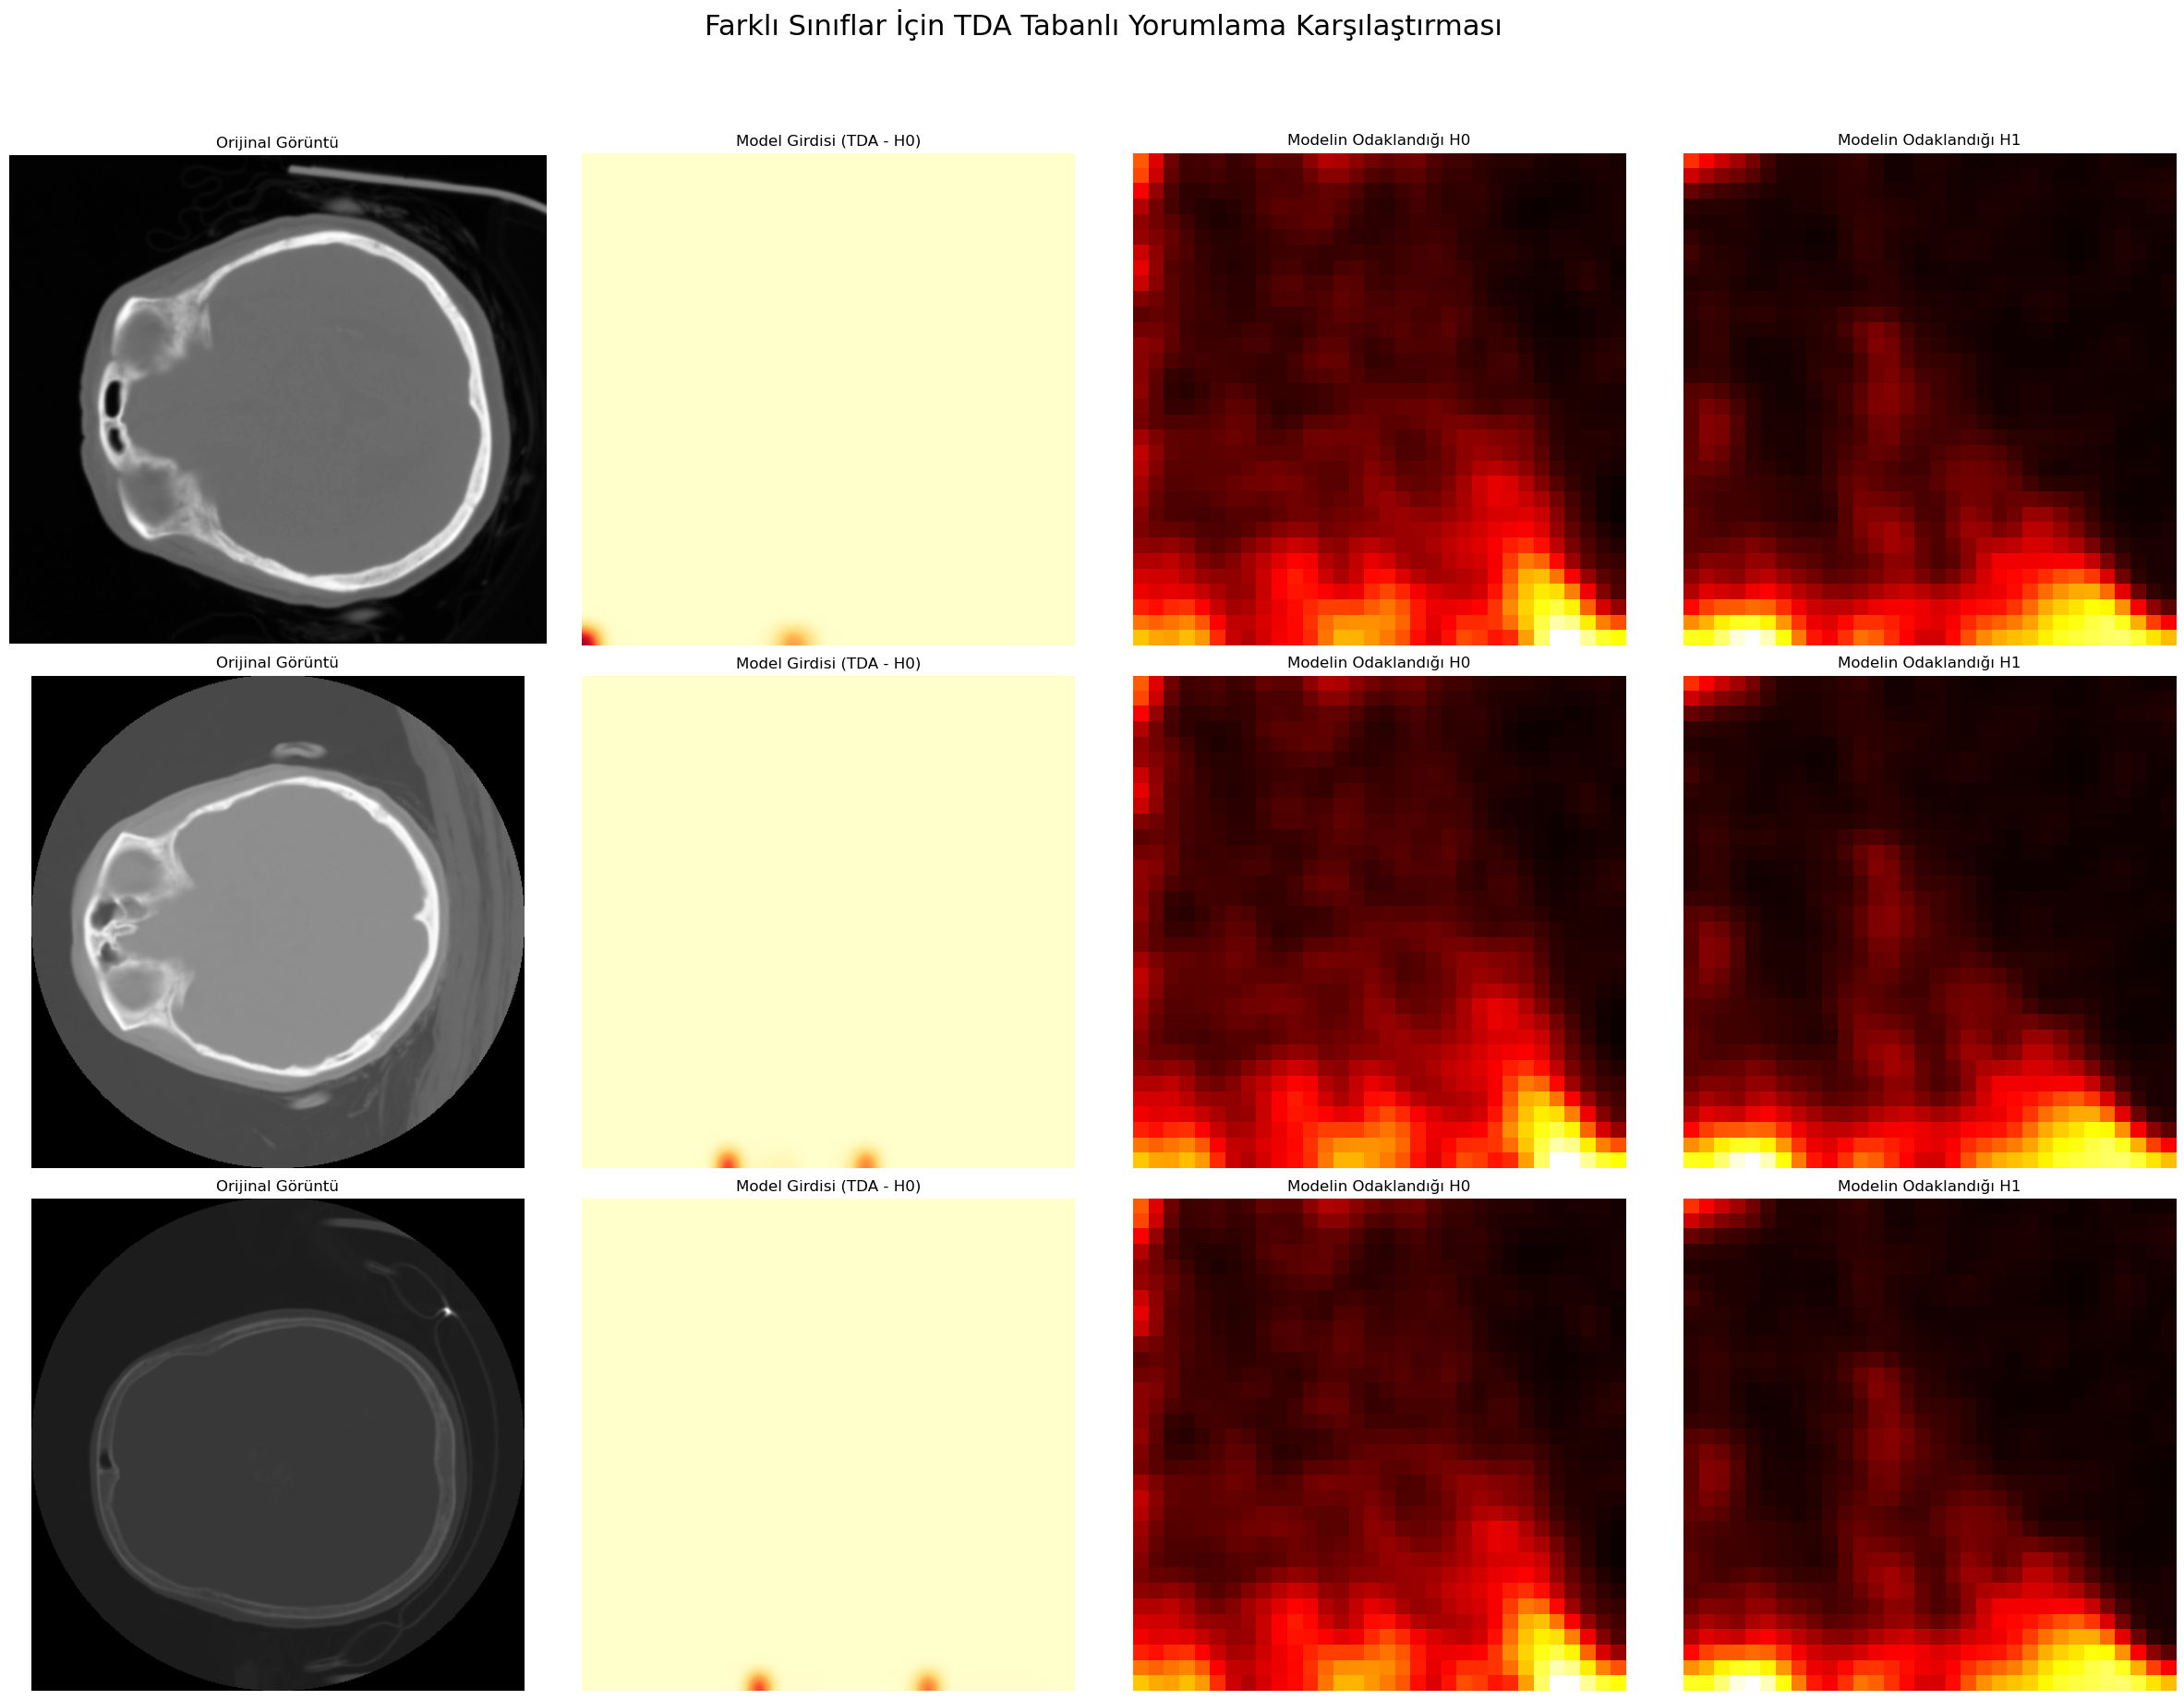

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from monai.transforms import LoadImage 
from scipy.ndimage import gaussian_filter

# --- Sınıf Tanımları ve Model Yükleme ---
# HybridResNetUNet sınıfı, device, test_data, TDA_DIR, TRAIN_CLASSES, hybrid_model

indices_to_visualize = [0, 10, 15] # Normal, Ischemia, Bleeding için örnek indeksler
num_samples = len(indices_to_visualize)

# --- Görselleştirme Döngüsü ---

# Her örnek için bir satır, her görsel türü için bir sütun içeren bir figür oluştur
fig, axes = plt.subplots(num_samples, 4, figsize=(24, 6 * num_samples))
fig.suptitle('Farklı Sınıflar İçin TDA Tabanlı Yorumlama Karşılaştırması', fontsize=22, y=1.02)

for i, sample_idx in enumerate(indices_to_visualize):
    
    # --- Veri Yükleme ---
    sample_data_point = test_data[sample_idx]
    loader = LoadImage(image_only=True)
    image_numpy = np.asarray(loader(sample_data_point['image'])).squeeze()
    label_name = TRAIN_CLASSES[sample_data_point['label']]
    
    base_filename = os.path.basename(sample_data_point['image'])
    filename_without_ext = os.path.splitext(base_filename)[0]
    npy_path = os.path.join(TDA_DIR, f"{filename_without_ext}.npy")
    persistence_image_numpy = np.load(npy_path)

    image_tensor = torch.from_numpy(image_numpy).float().unsqueeze(0).unsqueeze(0).to(device)
    tda_tensor = torch.from_numpy(persistence_image_numpy).float().unsqueeze(0).to(device)
    
    # --- Gradyan Hesaplama ---
    tda_tensor.requires_grad = True
    output = hybrid_model(image_tensor, tda_tensor)
    score, predicted_idx = torch.max(output, 1)
    predicted_name = TRAIN_CLASSES[predicted_idx.item()]
    
    score.backward()
    tda_grad = tda_tensor.grad.data.abs().squeeze().cpu().numpy()
    
    hybrid_model.zero_grad()
    tda_tensor.grad.zero_()
    
    # Bulanıklaştırma
    sigma = 1.0
    heatmap_h0 = gaussian_filter(tda_grad[0], sigma=sigma)
    heatmap_h1 = gaussian_filter(tda_grad[1], sigma=sigma)

    # --- O Satır İçin Çizim ---
    
    row_title = f"Örnek {i+1} (İndeks: {sample_idx}) | Gerçek Sınıf: {label_name} | Tahmin: {predicted_name}"
    axes[i, 0].set_ylabel(row_title, fontsize=14, rotation=0, labelpad=120, ha='center', va='center')

    # 1. Orijinal Görüntü
    axes[i, 0].imshow(image_numpy, cmap='gray')
    axes[i, 0].set_title('Orijinal Görüntü')
    axes[i, 0].axis('off')

    # 2. Model Girdisi (TDA - H0)
    axes[i, 1].imshow(persistence_image_numpy[0], cmap='YlOrRd')
    axes[i, 1].set_title('Model Girdisi (TDA - H0)')
    axes[i, 1].axis('off')

    # 3. Modelin Odaklandığı H0 Özellikleri
    im1 = axes[i, 2].imshow(heatmap_h0, cmap='hot')
    axes[i, 2].set_title('Modelin Odaklandığı H0')
    axes[i, 2].axis('off')

    # 4. Modelin Odaklandığı H1 Özellikleri
    im2 = axes[i, 3].imshow(heatmap_h1, cmap='hot')
    axes[i, 3].set_title('Modelin Odaklandığı H1')
    axes[i, 3].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

In [ ]:
import torch
import numpy as np
from tqdm import tqdm

def get_predictions_and_labels(model, data_loader, model_type="baseline"):
    all_preds = []
    all_labels = []
    
    model.eval()
    with torch.no_grad():
        for batch_data in tqdm(data_loader, desc=f"Test Seti Tahminleri ({model_type.capitalize()})"):
            labels = batch_data["label"]
            inputs = batch_data["image"].to(device)
            
            if model_type == "hybrid":
                tda_features = batch_data["tda_feature"].to(device)
                outputs = model(inputs, tda_features)
            else: # baseline
                outputs = model(inputs)
            
            predicted_indices = torch.argmax(outputs, dim=1)
            
            all_preds.extend(predicted_indices.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    return all_preds, all_labels

# --- Hipotez Testi ---

print("--- Hipotez Testi: TDA Kolu Kararı Etkiliyor mu? ---")
hybrid_model.eval()

# 2.1: Gerçek TDA verileriyle yapılan tahminleri ve etiketleri toplayalım
y_pred_real_tda, y_true = get_predictions_and_labels(
    hybrid_model, 
    hybrid_test_loader, 
    "hybrid"
)
# 2.2: Şimdi, TDA girdisini "susturarak" tekrar tahmin yapalım
y_pred_fake_tda = []
with torch.no_grad():
    for batch_data in tqdm(hybrid_test_loader, desc="Sahte TDA Verisiyle Tahmin"):
        inputs = batch_data["image"].to(device)
        
        # --- KRİTİK ADIM: Gerçek TDA verisi yerine sıfırlardan oluşan bir tensör veriyoruz ---
        fake_tda_features = torch.zeros_like(batch_data["tda_feature"]).to(device)
        
        # Modeli sahte TDA verisiyle çalıştır
        outputs = hybrid_model(inputs, fake_tda_features)
        
        predicted_indices = torch.argmax(outputs, dim=1)
        
        y_pred_fake_tda.extend(predicted_indices.cpu().numpy())

# --- Sonuçları Karşılaştıralım ---
# İki tahmin listesini NumPy dizisine çevir
y_pred_real_tda = np.array(y_pred_real_tda)
y_pred_fake_tda = np.array(y_pred_fake_tda)

matching_predictions = np.sum(y_pred_real_tda == y_pred_fake_tda)
total_predictions = len(y_pred_real_tda)
match_percentage = 100 * matching_predictions / total_predictions

print("\n" + "="*50)
print("--- TEST SONUCU ---")
print(f"Toplam {total_predictions} test örneği üzerinde karşılaştırma yapıldı.")
print(f"Gerçek TDA ile yapılan tahminler ile Sahte TDA (sıfırlar) ile yapılan tahminler arasındaki eşleşme sayısı: {matching_predictions}")
print(f"Eşleşme Oranı: {match_percentage:.2f}%")
print("="*50)

if match_percentage > 95:
    print("\nBULGU: Eşleşme oranı çok yüksek. Bu, modelin karar verirken TDA özelliklerini büyük ölçüde GÖRMEZDEN GELDİĞİNİ gösteriyor.")
    print("Bu nedenle, gradyan tabanlı ısı haritaları her seferinde aynı ve anlamsız bir sonuç üretiyordu.")
    print("\nTEZ İÇİN ÇIKARIM: Bu mimari ve eğitim stratejisi altında, güçlü ResNet18 kolu, TDA kolundan gelen sinyali domine etmiştir.")
elif match_percentage < 50:
    print("\nBULGU: Eşleşme oranı çok düşük. Bu, modelin TDA verisini ÖNEMLİ ÖLÇÜDE kullandığını gösteriyor.")
    print("Isı haritalarının sabit kalmasının sebebi, muhtemelen kütüphane kaynaklı bir gradyan akış problemidir.")
else:
    print("\nBULGU: Eşleşme oranı orta seviyede. Model TDA verisini bir miktar kullanıyor ancak bu etki her zaman belirleyici değil.")

--- Hipotez Testi: TDA Kolu Kararı Etkiliyor mu? ---


Sahte TDA Verisiyle Tahmin: 100%|██████████| 125/125 [00:30<00:00,  4.15it/s]


--- TEST SONUCU ---
Toplam 998 test örneği üzerinde karşılaştırma yapıldı.
Gerçek TDA ile yapılan tahminler ile Sahte TDA (sıfırlar) ile yapılan tahminler arasındaki eşleşme sayısı: 997
Eşleşme Oranı: 99.90%

BULGU: Eşleşme oranı çok yüksek. Bu, modelin karar verirken TDA özelliklerini büyük ölçüde GÖRMEZDEN GELDİĞİNİ gösteriyor.
Bu nedenle, gradyan tabanlı ısı haritaları her seferinde aynı ve anlamsız bir sonuç üretiyordu.

TEZ İÇİN ÇIKARIM: Bu mimari ve eğitim stratejisi altında, güçlü ResNet18 kolu, TDA kolundan gelen sinyali domine etmiştir.



### "Madem hibrit model daha iyi, neden hipotez testimiz (%99.90 eşleşme) modelin TDA kolunu neredeyse tamamen görmezden geldiğini gösterdi?"

→En Güçlü Açıklama: Regularizasyon Etkisi (The "Side Effect" Benefit)

Bu en olası ve en zarif açıklamadır. Modeliniz, TDA kolundan gelen bilgiyi doğrudan karar vermek için **kullanmıyor** olabilir, ancak TDA kolunun **varlığı**, ResNet kolunun daha iyi öğrenmesini **sağlıyor** olabilir.

Buna **örtük regularizasyon (implicit regularization)** denir.

**Nasıl Çalışır?**
1.  **Daha Zor Bir Görev:** Hibrit modelin görevi, sadece görüntüye bakarak karar veren baseline modelden daha zordur. Model, hem görüntüden gelen çok güçlü ve karmaşık sinyali hem de TDA'dan gelen daha zayıf ve soyut sinyali aynı anda işlemek zorundadır.
2.  **Aşırı Öğrenmeyi (Overfitting) Engelleme:** Bu "zorluk", modeli bir nevi "terbiye eder". Model, sadece görüntüdeki en bariz, en kolay desenleri ezberlemek yerine (ki bu aşırı öğrenmeye yol açabilir), daha genel ve daha sağlam özellikler öğrenmeye zorlanır. TDA kolu, bir "gürültü" kaynağı gibi davranarak ResNet kolunun aşırı özgüvenli olmasını ve veriyi ezberlemesini engeller.
3.  **Daha İyi Genelleme:** Sonuç olarak, ResNet kolu daha iyi genelleme yapan, yani daha önce görmediği test verilerinde daha iyi çalışan özellikler öğrenir. Modelin son kararı neredeyse tamamen bu daha iyi öğrenilmiş ResNet özelliklerine dayandığı için, TDA kolunu "susturduğumuzda" bile sonuçlar değişmez.

**Benzetme:** Bir öğrencinin sadece ders kitabından değil, aynı zamanda daha zor ve soyut felsefe metinlerinden de sorumlu olduğunu düşünün. Sınavda sadece ders kitabından soru çıksa bile, felsefe metinleriyle uğraşırken geliştirdiği analitik düşünme becerisi, o ders kitabı sorularını daha iyi çözmesini sağlar. Burada TDA, o "felsefe metni" gibidir.




"Hipotez testimiz, hibrit modelin nihai kararını verirken TDA özelliklerini doğrudan kullanmadığını gösterse de, hibrit modelin baseline modelden daha yüksek bir doğruluk oranına ulaşması, TDA kolunun bir **örtük regularizasyon mekanizması** olarak işlev gördüğüne işaret etmektedir. TDA verisinin varlığı, modelin görüntü işleme kolunu aşırı öğrenmeden koruyarak daha iyi genelleme yapmasını sağlamış ve bu da test seti performansında artışa yol açmıştır."


---
### Diğer Olası Sebepler

1.  **Marjinal Katkı:** Belki de TDA kolu tamamen görmezden gelinmiyor, ancak katkısı o kadar küçük ki, sadece 998 test örneğinden 1 tanesinde (%0.1) sonucu değiştirmeye yetiyor. O tek bir örnek bile, şans eseri kritik bir vaka olabilir ve genel metrikleri (özellikle sınıf bazında) sizin lehinize çevirebilir. `classification_report`'u tekrar detaylıca inceleyin. Belki de `Bleeding` sınıfından sadece 1 örneği daha doğru bilmesi, genel F1 skorunu etkilemiştir.

2.  **Farklı Başlangıç Noktası (Random Initialization):** Hibrit modelin mimarisi, baseline modelden farklıdır. Bu, eğitim başladığında ağırlıklarının tamamen farklı rastgele değerlerle başladığı anlamına gelir. Bazen, sırf bu başlangıç noktasının şans eseri daha iyi bir "vadiye" (optimizasyon uzayında) denk gelmesi bile, marjinal olarak daha iyi bir sonuca yol açabilir. Bu daha az olası ama teknik olarak mümkündür.
---


### Sonuç ve Tavsiye
*   **Bulgu 1:** Hibrit model, baseline modelden daha iyi performans gösterdi.
*   **Bulgu 2:** Ancak yapılan testler, bu performans artışının TDA verisinin doğrudan kullanılmasından değil, TDA kolunun ResNet kolu üzerinde yarattığı **dolaylı bir regularizasyon etkisinden** kaynaklandığını güçlü bir şekilde göstermektedir.
